In [1]:
%load_ext autoreload
%autoreload 2

import sys, pickle
sys.path.append('/home/andy/Documents/Research/software/basecode/')
from importscript import *

import tqdm
no_warnings()

In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model

2.2.0


### Download data

In [3]:
query = """with p as (select * from andy_everall.p02d_estimated
                        order by random()
                        limit 10000)
        select p.*, p5.*, g.* from p
            left join lateral (select astrometric_sigma5d_max from andy_everall.gaia2_rand100m as g
                                    where g.source_id=p.source_id) as g on true
            left join lateral (select ra_ra_p + dec_dec_p as p0_5 from andy_everall.gaia2_rand100m_prec5 as p5
                                    where p5.source_id=p.source_id) as p5 on true"""
%time _data = sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 48 ms, sys: 64 ms, total: 112 ms
Wall time: 2min 19s


## Training and testing

In [4]:
ast5d = np.arange(len(_data['source_id']))[_data['astrometric_params_solved']==31]
ast2d = np.arange(len(_data['source_id']))[_data['astrometric_params_solved']==3]

train = np.sort(np.random.choice(ast5d, int(0.8*len(ast5d)), replace=False))
test  = np.setdiff1d(ast5d, train)

## Neural network

In [5]:
log = lambda x: np.log(x)
logit = lambda x: np.log(x/(1-x))
logit_pm1 = lambda x: np.log((x+1)/(1-x))

In [6]:
features = ['astrometric_sigma5d_max', 'p0_2', 'ra_error', 'dec_error', 'ra_dec_corr']
trans = [log, log, log, log, logit_pm1]
labels = 'p0_5'

x_train = np.vstack([trans[i](_data[features[i]][train]) for i in range(len(features))]).T
x_test =  np.vstack([trans[i](_data[features[i]][test]) for i in range(len(features))]).T

y_train = np.log(_data[labels][train])
y_test = np.log(_data[labels][test])

x_pred =  np.vstack([trans[i](_data[features[i]][ast2d]) for i in range(len(features))]).T

In [7]:
model = tf.keras.Sequential([layers.Dense(units=1),
                             ])


model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

progress = model.fit(
    x_train, y_train, 
    epochs=10, verbose=False,
    validation_split =0.2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Text(0, 0.5, 'Error [MPG]')

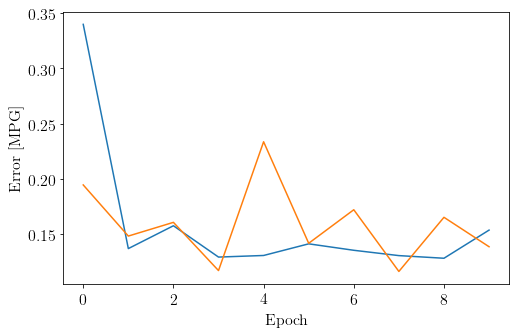

In [8]:
plt.figure(figsize=(8,5))
plt.plot(progress.history['loss'], label='loss')
plt.plot(progress.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Error [MPG]')

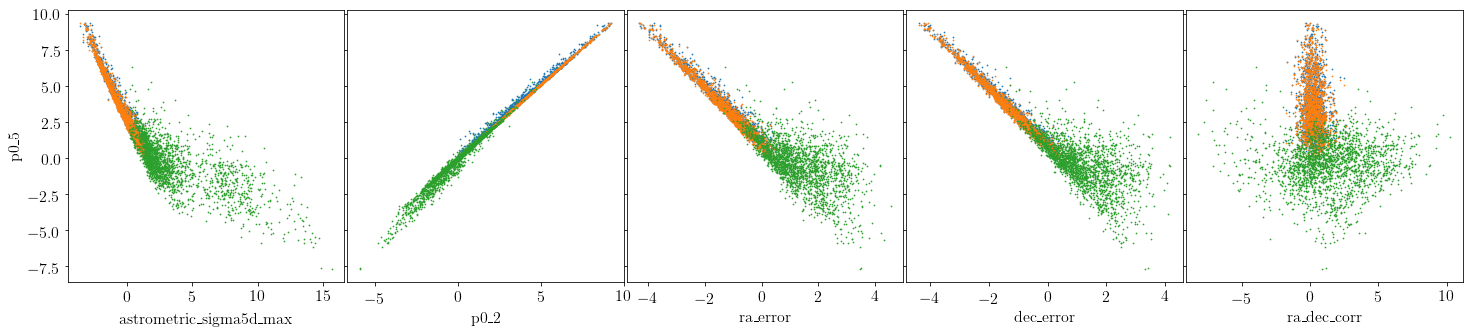

In [9]:
ndim = x_test.shape[1]#+1
fig, axes = plt.subplots(1,ndim, figsize=(5*ndim,5),sharey=True)

plt.sca(axes[0]);plt.ylabel(labels.replace('_', '\_'))
for i in range(ndim):
    plt.sca(axes[i])
    plt.scatter(x_test[:,i], y_test, s=0.5, label='Truth')
    plt.scatter(x_test[:,i], model.predict(x_test), s=0.5, label='Model')
    
    plt.scatter(x_pred[:,i], model.predict(x_pred), s=0.5, label='Predictions')
    plt.xlabel(features[i].replace('_','\_'))
plt.subplots_adjust(wspace=0.01)


### Distribution prediction

In [13]:
sys.path.append('../p0_estimation/')
from nn_functions import gaussian_layer, negative_gaussian_loss

In [17]:
# This is essentially linear regression
model = tf.keras.Sequential([layers.Dense(units=2),
                             Lambda(gaussian_layer)])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=negative_gaussian_loss)

In [20]:
history = model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
197/197 [==============================] - 0s 1ms/step - loss: 1.9433
Epoch 2/10
197/197 [==============================] - 0s 1ms/step - loss: 1.3154
Epoch 3/10
197/197 [==============================] - 0s 1ms/step - loss: 1.0232
Epoch 4/10
197/197 [==============================] - 0s 1ms/step - loss: 0.7292
Epoch 5/10
197/197 [==============================] - 0s 1ms/step - loss: 0.1872
Epoch 6/10
197/197 [==============================] - 0s 2ms/step - loss: 1.5691
Epoch 7/10
197/197 [==============================] - 0s 1ms/step - loss: -0.9677
Epoch 8/10
197/197 [==============================] - 0s 1ms/step - loss: -0.9964
Epoch 9/10
197/197 [==============================] - 0s 1ms/step - loss: -0.2510
Epoch 10/10
197/197 [==============================] - 0s 1ms/step - loss: -1.0007


In [23]:
history.history

{'loss': [-1.0971533060073853,
  -0.9992709755897522,
  -1.126038908958435,
  0.3022553324699402,
  -1.1328898668289185,
  -1.0718300342559814,
  -0.37228134274482727,
  3.2078700065612793,
  2.007784605026245,
  0.18165923655033112,
  -1.1067594289779663,
  0.8088639378547668,
  -0.43537870049476624,
  -1.065545916557312,
  -0.8535997271537781,
  -1.0759493112564087,
  -0.8833016157150269,
  -1.1253502368927002,
  -0.5465927720069885,
  -1.154211401939392]}

Text(0, 0.5, 'Error [MPG]')

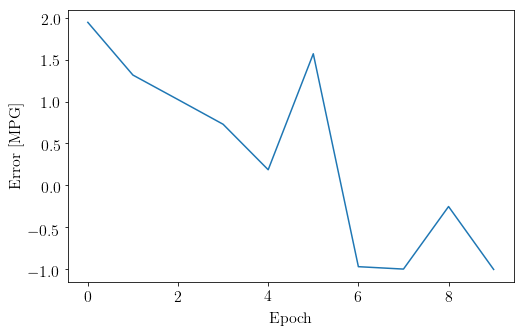

In [21]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch'); plt.ylabel('Error [MPG]')

In [25]:
def reduced_chi2(model, x_test, y_test):
    
    mu_pred, sigma_pred = model.predict(x_test).T
    
    return np.sum((y_test-mu_pred)**2/sigma_pred**2)/len(y_test)

In [23]:
reduced_chi2(model, x_test, y_test)

1.002876218535216

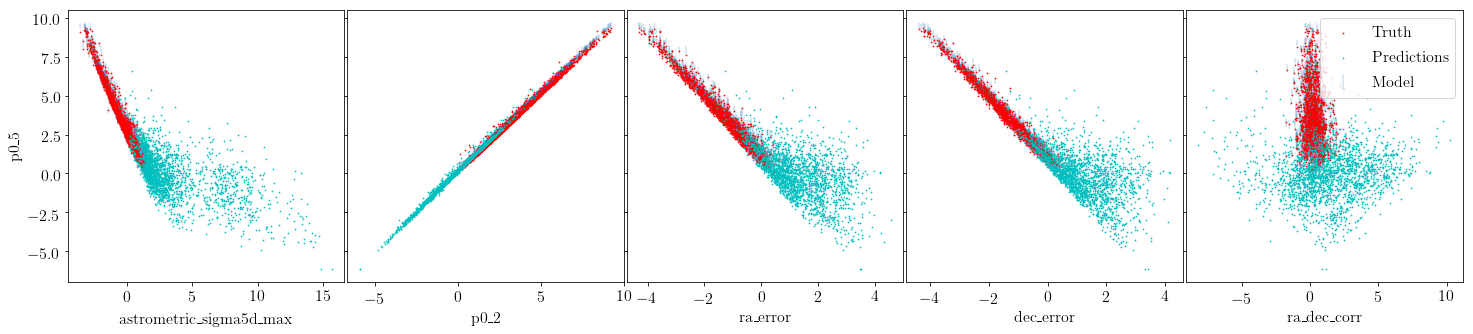

In [24]:
ndim = x_test.shape[1]
fig, axes = plt.subplots(1,ndim, figsize=(5*ndim,5),sharey=True)

plt.sca(axes[0]);plt.ylabel(labels.replace('_', '\_'))
for i in range(ndim):
    plt.sca(axes[i])
    plt.scatter(x_test[:,i], y_test, s=0.5, label='Truth', color='r')
    plt.errorbar(x_test[:,i], model.predict(x_test).T[0], model.predict(x_test).T[1], 
             label='Model', marker='o', linestyle="", markersize=0.3, alpha=0.2, zorder=0)
    
    plt.scatter(x_pred[:,i], model.predict(x_pred).T[0], s=0.5, label='Predictions', color='c')
    plt.xlabel(features[i].replace('_','\_'))
    
plt.legend()
plt.subplots_adjust(wspace=0.01)

^ this does not work well every time. It seems like the parameter values get caught in local optima a lot!

# Input transformation

In [6]:
sys.path.append('../p0_estimation/')
from nn_functions import logit, expit

In [7]:
features = ['astrometric_sigma5d_max', 'p0_2', 'ra_error', 'dec_error', 'ra_dec_corr']
labels = 'p0_5'

x_train = np.vstack([_data[features[i]][train] for i in range(len(features))]).T
x_test =  np.vstack([_data[features[i]][test] for i in range(len(features))]).T

y_train = np.log(_data[labels][train])
y_test = np.log(_data[labels][test])

x_pred =  np.vstack([_data[features[i]][ast2d] for i in range(len(features))]).T

In [8]:
log=lambda x: tf.math.log(x)
logit=lambda x: tf.math.log((1+x)/(1-x))
trans = [log,log,log,log,logit]

In [9]:
class TransformInput():
    
    def __init__(self, transform, name=None):
        
        self.transform=transform
        
    def __call__(self, inputs):

        unstacked = tf.unstack(inputs, axis=1)
        
        out = []
        for ii in range(len(unstacked)):
            out.append(trans[ii](unstacked[ii]))
        
        #return inputs
        return tf.stack(out, axis=1)

In [52]:
# This is essentially linear regression
model = tf.keras.Sequential([Lambda(TransformInput(trans)),
                             layers.Dense(units=2),
                             Lambda(gaussian_layer)])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=negative_gaussian_loss)

In [53]:
model(x_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(6312, 2), dtype=float32, numpy=
array([[-1.5524176 ,  0.9522383 ],
       [-2.7721994 ,  0.4977215 ],
       [-1.5715079 ,  0.7214156 ],
       ...,
       [-0.7840072 ,  0.64128935],
       [-2.164273  ,  0.7127824 ],
       [-2.749586  ,  0.75339156]], dtype=float32)>

In [58]:
history = model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
198/198 [==============================] - 0s 1ms/step - loss: 4.0750
Epoch 2/10
198/198 [==============================] - 0s 1ms/step - loss: -0.1531
Epoch 3/10
198/198 [==============================] - 0s 1ms/step - loss: -1.1390
Epoch 4/10
198/198 [==============================] - 0s 1ms/step - loss: -1.1516
Epoch 5/10
198/198 [==============================] - 0s 1ms/step - loss: -1.0011
Epoch 6/10
198/198 [==============================] - 0s 1ms/step - loss: -0.9566
Epoch 7/10
198/198 [==============================] - 0s 1ms/step - loss: -0.5380
Epoch 8/10
198/198 [==============================] - 0s 1ms/step - loss: -0.9902
Epoch 9/10
198/198 [==============================] - 0s 1ms/step - loss: -1.0867
Epoch 10/10
198/198 [==============================] - 0s 1ms/step - loss: -0.6588


Text(0, 0.5, 'Error [MPG]')

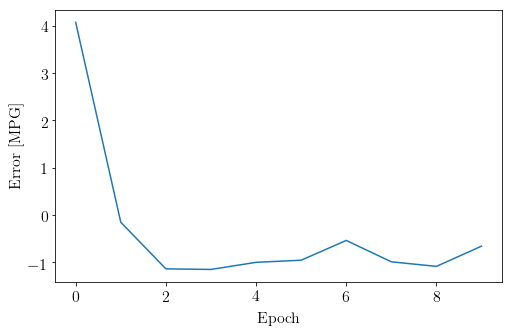

In [59]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch'); plt.ylabel('Error [MPG]')

In [60]:
reduced_chi2(model, x_test, y_test)

1.6873235326282217

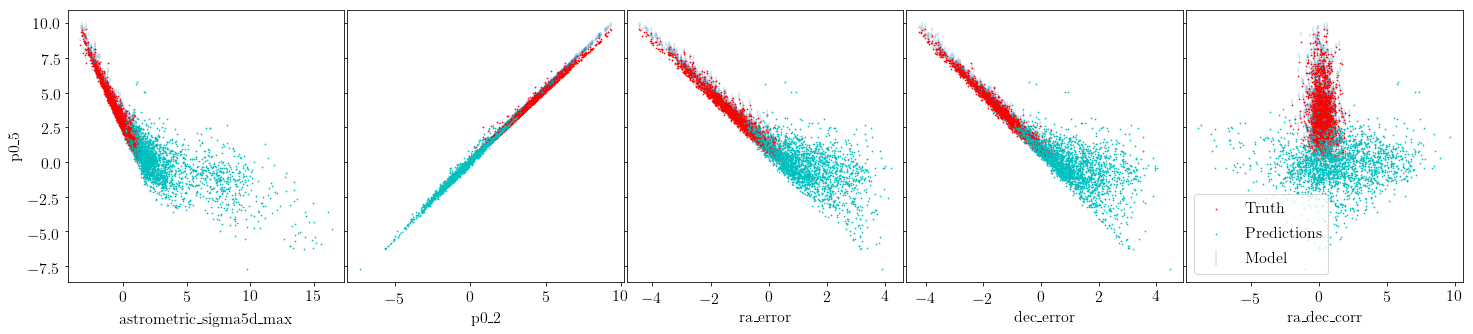

In [61]:
ndim = x_test.shape[1]#+1
fig, axes = plt.subplots(1,ndim, figsize=(5*ndim,5),sharey=True)

plt.sca(axes[0]);plt.ylabel(labels.replace('_', '\_'))
for i in range(ndim):
    plt.sca(axes[i])
    plt.scatter(trans[i](x_test[:,i]), y_test, s=0.5, label='Truth', color='r')
    plt.errorbar(trans[i](x_test[:,i]), model.predict(x_test).T[0], model.predict(x_test).T[1], 
             label='Model', marker='o', linestyle="", markersize=0.3, alpha=0.2, zorder=0)
    
    plt.scatter(trans[i](x_pred[:,i]), model.predict(x_pred).T[0], s=0.5, label='Predictions', color='c')
    plt.xlabel(features[i].replace('_','\_'))
    
plt.legend()
plt.subplots_adjust(wspace=0.01)

# Multi-Layer ReLU Network

In [208]:
log=lambda x: tf.math.log(x)+10
logit=lambda x: tf.math.log((1+x)/(1-x))
trans = [log,log,log,log,logit]

In [230]:
# ReLU makes the model much more complex
model = tf.keras.Sequential([Lambda(TransformInput(trans)),
                             layers.Dense(units=2, activation='relu'),
                             Lambda(gaussian_layer)])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=negative_gaussian_loss)

In [231]:
model(x_train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[16.188387]
 [12.65591 ]
 [14.194796]
 ...
 [17.364126]
 [14.533847]
 [13.020301]], shape=(6311, 1), dtype=float32)


<tf.Tensor: shape=(6311, 2), dtype=float32, numpy=
array([[1.61883869e+01, 1.35033900e+07],
       [1.26559095e+01, 1.30381096e+08],
       [1.41947956e+01, 5.10822240e+07],
       ...,
       [1.73641262e+01, 6.59156000e+06],
       [1.45338469e+01, 6.76705040e+07],
       [1.30203009e+01, 1.13220896e+08]], dtype=float32)>

In [221]:
history = model.fit(x_train, y_train+10, epochs = 10)

Epoch 1/10
Tensor("sequential_49/lambda_103/ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("sequential_49/lambda_103/ExpandDims:0", shape=(None, 1), dtype=float32)
198/198 [==============================] - 0s 2ms/step - loss: 0.6832
Epoch 2/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0194
Epoch 3/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 4/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 5/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 6/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0275
Epoch 7/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 8/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 9/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 10/10
198/198 [==============================] - 0s 1ms/step - loss: 0.0298


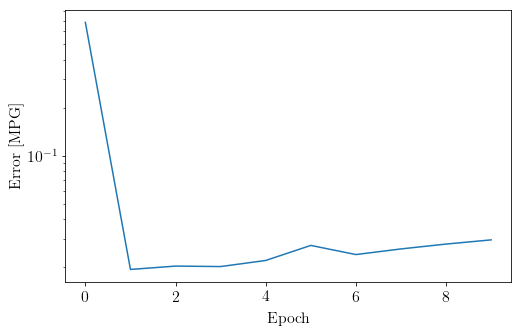

In [222]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch'); plt.ylabel('Error [MPG]'); plt.yscale('log')

In [223]:
reduced_chi2(model, x_test, y_test+10)

Tensor("sequential_49/lambda_103/ExpandDims:0", shape=(None, 1), dtype=float32)


0.02967364204482211

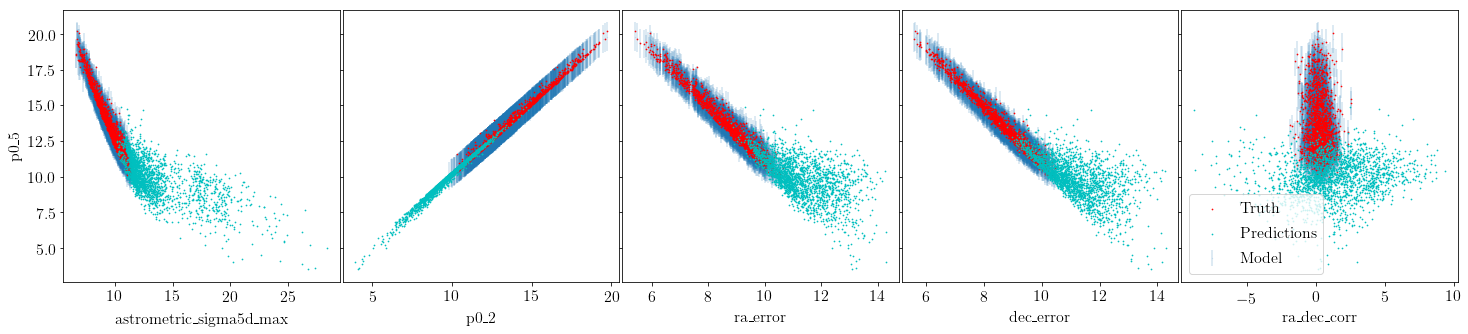

In [224]:
ndim = x_test.shape[1]#+1
fig, axes = plt.subplots(1,ndim, figsize=(5*ndim,5),sharey=True)

plt.sca(axes[0]);plt.ylabel(labels.replace('_', '\_'))
for i in range(ndim):
    plt.sca(axes[i])
    plt.scatter(trans[i](x_test[:,i]), y_test+10, s=0.5, label='Truth', color='r')
    plt.errorbar(trans[i](x_test[:,i]), model.predict(x_test).T[0], model.predict(x_test).T[1], 
             label='Model', marker='o', linestyle="", markersize=0.3, alpha=0.2, zorder=0)
    
    plt.scatter(trans[i](x_pred[:,i]), model.predict(x_pred).T[0], s=0.5, label='Predictions', color='c')
    plt.xlabel(features[i].replace('_','\_'))
    
plt.legend()
plt.subplots_adjust(wspace=0.01)